# Dataset Splitting, PCA and SVMs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from collections import Counter
import pickle

In [2]:
full_vec = np.load('full_vec.npy')
full_vec.shape

(9222, 420)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
trainX, testX, trainY, testY = train_test_split(full_vec[:,:-4], full_vec[:,-4:], test_size=0.2, random_state=42)
print('{:17}{:d}x{:d}'.format('Training set is.',*trainX.shape))
print('{:17}{:d}x{:d}'.format('Testing set is..',*testX.shape))

Training set is. 7377x416
Testing set is.. 1845x416


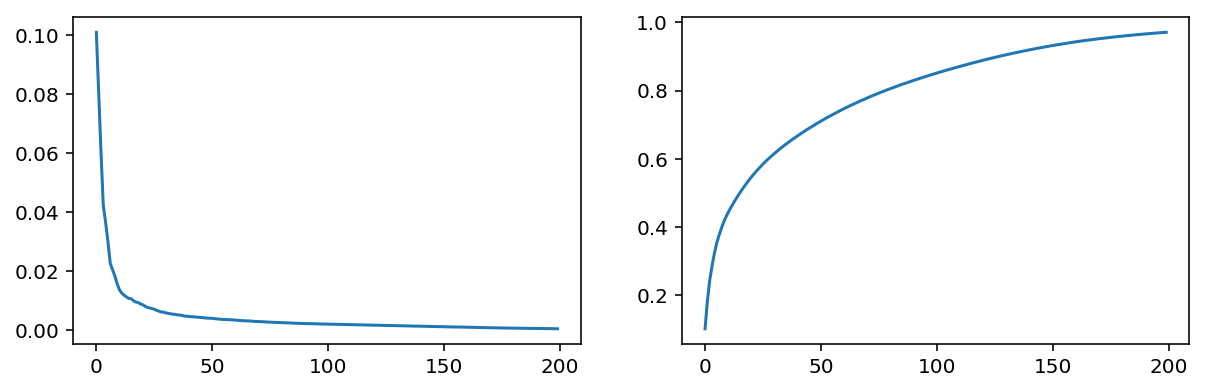

In [5]:
pca=PCA(n_components=200)
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca)])
trainX_pcaed=pipeline.fit_transform(trainX)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(pca.explained_variance_ratio_)
plt.subplot(122)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [6]:
print('New data shape is %dx%d'%trainX_pcaed.shape)
print('Amount of variance explained = %.2f'%  np.sum(pca.explained_variance_ratio_))

New data shape is 7377x200
Amount of variance explained = 0.97


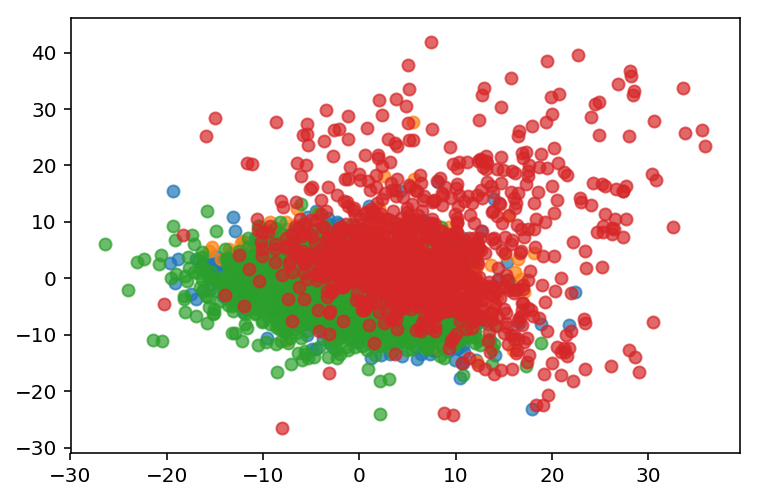

In [7]:
for i in range(4):
    _X, _Y = trainX_pcaed[np.argmax(trainY, axis=1)==i][:,0], trainX_pcaed[np.argmax(trainY, axis=1)==i][:,1]
    plt.scatter(_X, _Y, alpha=0.7)

### Testing an SVM

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [9]:
trainY_argmax=np.argmax(trainY, axis=1)

In [10]:
pca=PCA(n_components=416)
clf = SVC(C=2.5, gamma='auto', probability=True)
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca), ('svc', clf)])
fit=pipeline.fit(trainX, trainY_argmax)

In [25]:
test_blind=np.load('blind_vec.npy')[:,:]

In [26]:
pred_test=pipeline.predict_proba(test_blind)

In [27]:
pred_test[-20:,:]

array([[ 0.08167353,  0.05610189,  0.09275881,  0.76946576],
       [ 0.06464954,  0.04816838,  0.06345289,  0.82372918],
       [ 0.06142761,  0.04638229,  0.06035527,  0.83183483],
       [ 0.06159182,  0.04567522,  0.05878867,  0.83394429],
       [ 0.0630272 ,  0.04672624,  0.06167516,  0.82857139],
       [ 0.12475849,  0.07049396,  0.14780137,  0.65694618],
       [ 0.06976932,  0.04993139,  0.07100693,  0.80929236],
       [ 0.08119433,  0.05663829,  0.08204514,  0.78012223],
       [ 0.07154364,  0.05176956,  0.07283761,  0.80384919],
       [ 0.06031256,  0.04629522,  0.05728252,  0.83610969],
       [ 0.06965864,  0.05031283,  0.07099256,  0.80903598],
       [ 0.11706111,  0.07576086,  0.1255524 ,  0.68162564],
       [ 0.06183447,  0.04606626,  0.05888236,  0.83321691],
       [ 0.07280097,  0.05022033,  0.07361715,  0.80336155],
       [ 0.09228717,  0.05627747,  0.11367437,  0.73776098],
       [ 0.06077441,  0.04768051,  0.06802421,  0.82352087],
       [ 0.07380503,  0.

In [100]:
pred_test=pipeline.predict(testX)

In [101]:
pred_test

array([2, 0, 3, ..., 2, 0, 0])

In [99]:
np.sum(pred_test == np.argmax(testY, axis=1))/pred_test.shape[0]

0.70081300813008129

In [56]:
parameters = {'svc__C':[1, 2.5, 5]}
pca=PCA(n_components=300)
sv = SVC()
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca), ('svc', sv)])
clf = GridSearchCV(pipeline, parameters)
clf.fit(trainX, trainY_argmax)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svc__C': [1, 2.5, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [57]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = np.argmax(testY, axis=1), clf.predict(testX)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'svc__C': 2.5}
Grid scores on development set:
0.687 (+/-0.020) for {'svc__C': 1}
0.692 (+/-0.013) for {'svc__C': 2.5}
0.688 (+/-0.010) for {'svc__C': 5}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
             precision    recall  f1-score   support

          0       0.61      0.66      0.64       611
          1       0.78      0.70      0.73       246
          2       0.72      0.66      0.69       671
          3       0.78      0.86      0.82       317

avg / total       0.70      0.70      0.70      1845



In [58]:
params = dict(reduce_dim__n_components=[2, 5, 10], clf__C=[0.1, 10, 100])

In [71]:
from sklearn.metrics import confusion_matrix
import itertools

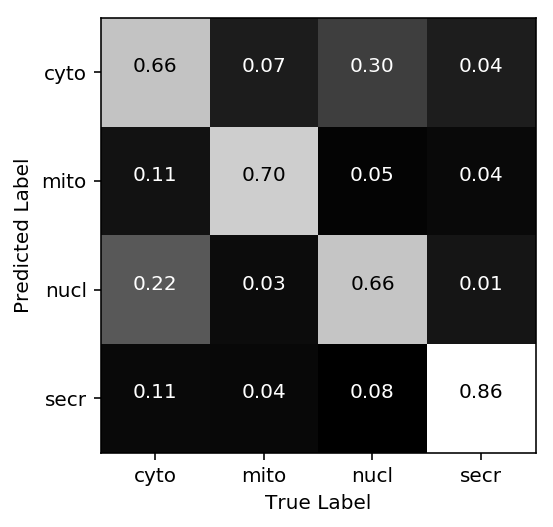

In [81]:
cm=confusion_matrix(y_true, y_pred)
cm_norm=cm/np.sum(cm, axis=1)
plt.imshow(cm_norm, cmap=plt.get_cmap('gray'))
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.xticks([0,1,2,3], ['cyto', 'mito', 'nucl', 'secr'])
plt.yticks([0,1,2,3], ['cyto', 'mito', 'nucl', 'secr'])
np.set_printoptions(precision=2)
for i,j in itertools.product(range(4), range(4)):
    plt.text(i,j, '%.2f'%cm_norm[i,j], horizontalalignment="center", color="black" if cm_norm[i, j] > 0.6 else "white")


In [ ]:
p